In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from torchinfo import summary
from adopt import ADOPT

In [79]:
data = pd.read_csv("data/data1003.csv")

In [80]:
print(f"The number of features available to us: {data.shape[1]}")
print(data.head(0))

The number of features available to us: 62
Empty DataFrame
Columns: [Unnamed: 0, time, DLWRF_surface, PRES_surface, SPFH_2maboveground, precip_rate, DSWRF_surface, TMP_2maboveground, UGRD_10maboveground, VGRD_10maboveground, APCP_surface, streamflow, elevation_mean, slope_mean, impervious_mean, aspect_c_mean, twi_dist_4, X, Y, gw_Coeff, gw_Zmax, gw_Expon, bexp_soil_layers_stag=1, bexp_soil_layers_stag=2, bexp_soil_layers_stag=3, bexp_soil_layers_stag=4, ISLTYP, IVGTYP, dksat_soil_layers_stag=1, dksat_soil_layers_stag=2, dksat_soil_layers_stag=3, dksat_soil_layers_stag=4, psisat_soil_layers_stag=1, psisat_soil_layers_stag=2, psisat_soil_layers_stag=3, psisat_soil_layers_stag=4, cwpvt, mfsno, mp, quartz_soil_layers_stag=1, quartz_soil_layers_stag=2, quartz_soil_layers_stag=3, quartz_soil_layers_stag=4, refkdt, slope, smcmax_soil_layers_stag=1, smcmax_soil_layers_stag=2, smcmax_soil_layers_stag=3, smcmax_soil_layers_stag=4, smcwlt_soil_layers_stag=1, smcwlt_soil_layers_stag=2, smcwlt_soil

In [81]:
def load_data_in_dictionary(data):
    '''This loads the data into a dictionary. each index of dictionary has a pair of watersheds, 
       upper and lower, and their features are merged in the for loop below'''
    num_networks = 0
    network_dict = {}
    broken_pairs = []
    for i in range(int((data['pair_id']).max())+1):
        try:
            downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
            upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]
            #print(downstream)
            #print(upstream)
            if downstream.empty or downstream.isnull().values.any():
                print(i, " DS is empty")
                continue
            if upstream.empty or upstream.isnull().values.any():
                print(i, " US is empty")
                continue
            '''area_ratio = upstream.iloc[0]["Shape_Area"] / downstream.iloc[0]["Shape_Area"]
            if area_ratio > 1:
                print(i, " area ratio too large")
                continue
            if abs(downstream.iloc[-1]['ID'] - upstream.iloc[-1]['ID']) > 100:
                print(i, " DS and US too far apart")
                continue'''
            network = downstream.merge(upstream, on="time")
            network.drop(["x_x", "y_x", "pair_id_x", "x_y", "y_y", "pair_id_y"], axis=1, inplace=True)
            network_dict[num_networks] = network
            num_networks += 1
        except:
            broken_pairs.append(i)
            raise Exception
    return network_dict, broken_pairs, num_networks



network_dict, num_networks, broken_pairs = load_data_in_dictionary(data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].streamflow_y}")

The number of networks we have:	7
The number of data points in each network:	696
The number of features in each network:	0      0.37
1      0.38
2      0.38
3      0.38
4      0.38
       ... 
691    0.40
692    0.40
693    0.40
694    0.40
695    0.40
Name: streamflow_y, Length: 696, dtype: float64


In [ ]:
#among all the features in the dataset, we will be working on thses features. If you want to add a new feature, see the datafile and add features as you like

lstm_inputs = [
    'precip_rate_x', 
    'APCP_surface_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    'APCP_surface_y', 
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

coorelation_heat_map_inputs = [
    # 'precip_rate_x', 
    'APCP_surface_x', 
               'TMP_2maboveground_x', 
    'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
    'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    # 'precip_rate_y', 
    'APCP_surface_y', 
    'TMP_2maboveground_y',
    'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
    'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

n_input = len(lstm_inputs)

lstm_outputs = ['streamflow_y']     #this is what we will be trying to predict using the LSTM model
n_output = len(lstm_outputs)
print(f"The number of features for LSTM model:\t{n_input}")

The number of features for LSTM model:	6


In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")
# hidden_state_size = ( n_input + n_output ) * 3   I've commented this out because I will arbitrarily assign it later inside the LSTM1 class definition
# num_layers = 1
# num_epochs = 5
batch_size = 1704
seq_length = 270
# learning_rate = np.linspace(start=0.0001, stop=0.00001, num=num_epochs)   better adding a learning rate scheduler


Using CUDA device: NVIDIA A100-SXM4-40GB


In [84]:
n_networks = len(network_dict)

n_networks_split = {"train": (math.floor(n_networks * 0.7)), "val": math.floor(n_networks * 0.3)}
print(n_networks_split['val'])

2


In [85]:
def split_parameters():
    # create lists of network indices for each set based on the given network splits
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split['val'] + 1))


    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]         #we are definitely missing out on the entire 80% of the dataset in validation

    return [train_split_parameters, val_split_parameters]

[[networks_for_training], [networks_for_val]] = split_parameters()
print(f"The networks for training is networks_for_training {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")

The networks for training is networks_for_training [0, 1, 2, 3, 4]
The networks for validation is [5, 6]


Network: 0
Streamflow (downstream) mean: 0.42
Streamflow (upstream) mean: 0.42


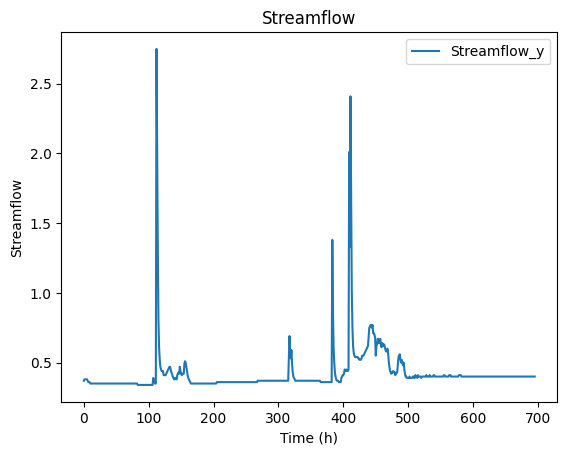

Network: 1
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.13


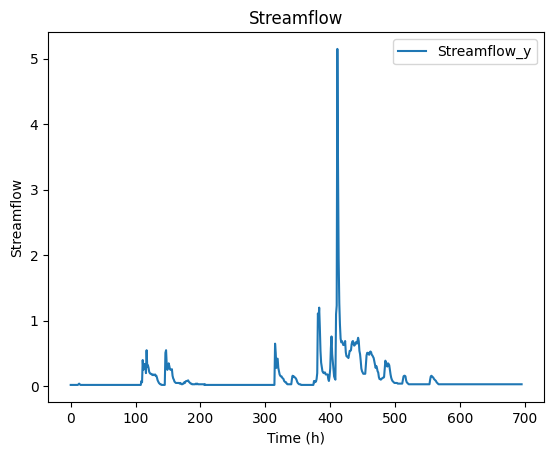

Network: 2
Streamflow (downstream) mean: 0.09
Streamflow (upstream) mean: 0.12


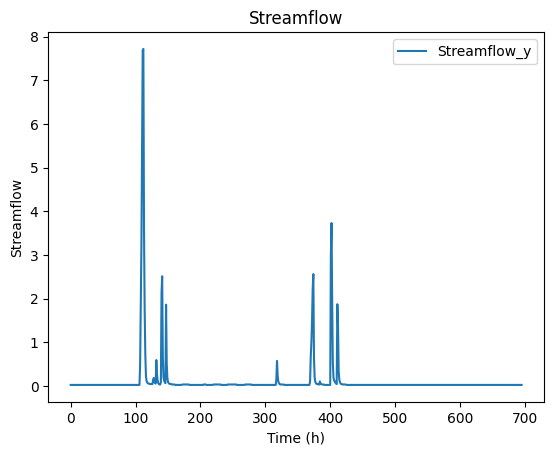

Network: 3
Streamflow (downstream) mean: 0.28
Streamflow (upstream) mean: 0.29


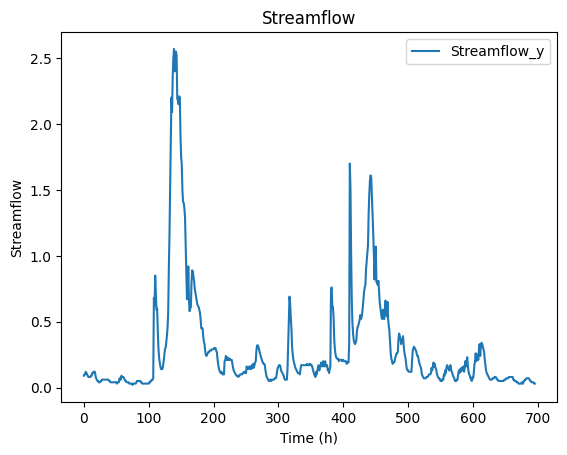

Network: 4
Streamflow (downstream) mean: 0.48
Streamflow (upstream) mean: 2.11


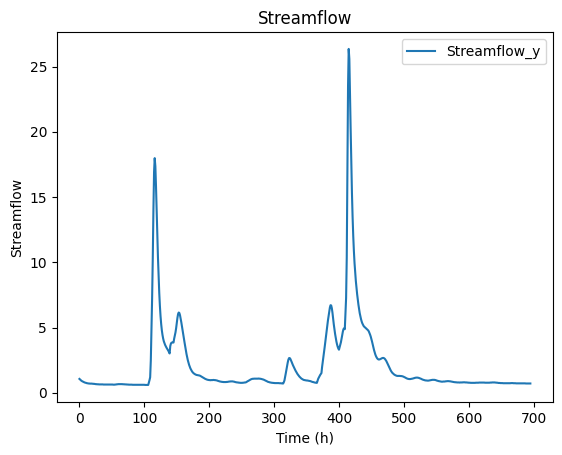

Network: 5
Streamflow (downstream) mean: 0.55
Streamflow (upstream) mean: 0.63


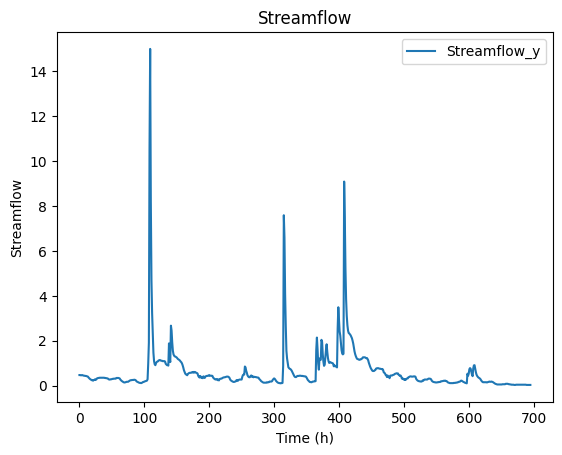

Network: 6
Streamflow (downstream) mean: 0.07
Streamflow (upstream) mean: 0.32


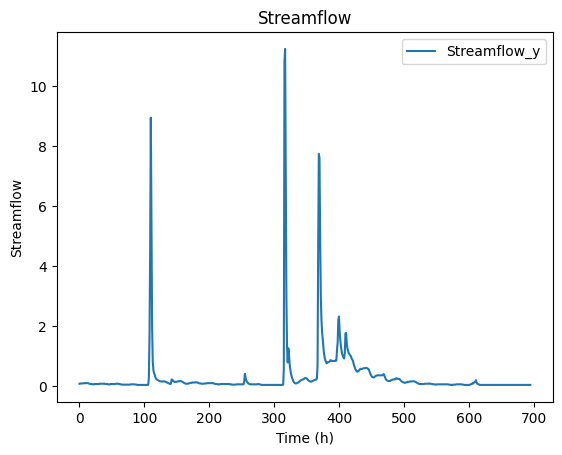

In [86]:
def viz_networks(ibuc):
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(),2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(),2))

    # network_dict[ibuc].loc[:2000,['precip_rate_x']].plot(ax=ax, legend=False)
    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['streamflow_x']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_x']].plot(ax=ax, legend=False)
    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y", "APCP_surface_x"])
    
    plt.show()
    plt.close()

def viz_networks2(ibuc):
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, color = 'blue', legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, color = 'purple', legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, color='orange', legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, color='red', legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    # plt.show()
    plt.close()

    

displayed = 0

for ibuc in networks_for_training:
    viz_networks(ibuc)
    displayed += 1


for ibuc in networks_for_val:
    viz_networks(ibuc)
    displayed += 1

In [87]:


class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x):
        # Pass through first LSTM layer
        out, _= self.lstm1(x)
        # Pass through second LSTM layer
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction



In [88]:

model = LSTM1(input_size=n_input, num_classes=n_output).to(device)
# x = torch.tensor(np.random.rand(256,24,29), dtype=torch.float32).to(device=device)
# print(model(x).shape)
# summary(model, (256,24,29))


In [89]:
def fit_scaler():
    frames = [network_dict[ibuc].loc[:, lstm_inputs] for ibuc in networks_for_training]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] for ibuc in networks_for_training]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [90]:
scaler_in, scaler_out = fit_scaler()

(3480, 6)
(3480, 1)


In [91]:
def make_data_loader(network_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in network_list:
        df = network_dict[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])
        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])
        
        n_samples = scaler_in_i.shape[0] - seq_length
        
        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) 

        for i in range(n_samples):
            t = i + seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]
            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]

        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]
        loader[ibuc] = ds
    return loader, np_seq_X, np_seq_y

In [92]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader([0,1,5,6])
# print(network_dict[0].loc[:, lstm_outputs])
# val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(networks_for_val)

In [93]:
print(train_loader[0][1].shape)

torch.Size([426, 1])


In [94]:
def concatanate_tensors(loader,  training_networks, training = True):
    if training == True:
        concatanated_tensor_x = loader[0][0]
        concatanated_tensor_y = loader[0][1]

        for i in range(len(training_networks) - 1):
            concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[training_networks[i+1]][0]))
            concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[training_networks[i+1]][1]))
        return concatanated_tensor_x, concatanated_tensor_y    
    # if training == False:
    #     concatanated_tensor_x = loader[offest_buckets][0]
    #     concatanated_tensor_y = loader[offest_buckets][1]

    #     for i in range(offest_buckets, len(loader) + offest_buckets - 1):
    #         concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[i+1][0]))
    #         concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[i+1][1]))
    #     return concatanated_tensor_x, concatanated_tensor_y   

  

In [95]:

train_data_x, train_data_y = concatanate_tensors(train_loader, [0,1,5,6])
# val_data_x, val_data_y = concatanate_tensors(val_loader, False, len(train_loader))


In [96]:
# print(train_data_x[0:500])
# print(train_data_y[0:500])
print(train_data_y.shape)
train_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)
train_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size)
# print(len(train_batch_loader))

torch.Size([1704, 1])


In [97]:
def train_model(lstm, train_loader):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr= .0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    epochs = 200
    loss_history = []
    for epoch in range(epochs):
        for data, targets in train_batch_loader:
            x = data.to(device=device)
            y = targets.to(device=device)

            optimizer.zero_grad()
            predicted_y = lstm(x)
            loss = criterion(predicted_y, y)

            loss_history.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step(loss)
        print(f"Epoch: {epoch} Completed")

    return lstm, loss_history

In [98]:
model, results = train_model(model, train_loader)

Epoch: 0 Completed


Epoch: 1 Completed
Epoch: 2 Completed
Epoch: 3 Completed
Epoch: 4 Completed
Epoch: 5 Completed
Epoch: 6 Completed
Epoch: 7 Completed
Epoch: 8 Completed
Epoch: 9 Completed
Epoch: 10 Completed
Epoch: 11 Completed
Epoch: 12 Completed
Epoch: 13 Completed
Epoch: 14 Completed
Epoch: 15 Completed
Epoch: 16 Completed
Epoch: 17 Completed
Epoch: 18 Completed
Epoch: 19 Completed
Epoch: 20 Completed
Epoch: 21 Completed
Epoch: 22 Completed
Epoch: 23 Completed
Epoch: 24 Completed
Epoch: 25 Completed
Epoch: 26 Completed
Epoch: 27 Completed
Epoch: 28 Completed
Epoch: 29 Completed
Epoch: 30 Completed
Epoch: 31 Completed
Epoch: 32 Completed
Epoch: 33 Completed
Epoch: 34 Completed
Epoch: 35 Completed
Epoch: 36 Completed
Epoch: 37 Completed
Epoch: 38 Completed
Epoch: 39 Completed
Epoch: 40 Completed
Epoch: 41 Completed
Epoch: 42 Completed
Epoch: 43 Completed
Epoch: 44 Completed
Epoch: 45 Completed
Epoch: 46 Completed
Epoch: 47 Completed
Epoch: 48 Completed
Epoch: 49 Completed
Epoch: 50 Completed
Epoch: 51

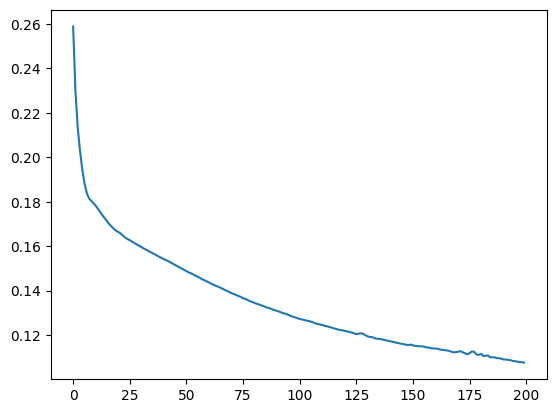

In [ ]:
plt.plot([i for i in range(len(results))], results)
plt.savefig('Loss_Function_Combined_Model')
plt.show()

In [100]:
print(results[-100:])

[0.12728877365589142, 0.12705406546592712, 0.12684330344200134, 0.12653958797454834, 0.12630650401115417, 0.12605595588684082, 0.1257084608078003, 0.12524805963039398, 0.12499911338090897, 0.12474044412374496, 0.12457746267318726, 0.12418857961893082, 0.12397676706314087, 0.12366972118616104, 0.12332046031951904, 0.12303026020526886, 0.12279736995697021, 0.12249711155891418, 0.12227381765842438, 0.12211698293685913, 0.12187561392784119, 0.12164729833602905, 0.12142221629619598, 0.12117547541856766, 0.12078119814395905, 0.1204376071691513, 0.1206335797905922, 0.12084400653839111, 0.12062271684408188, 0.11991477757692337, 0.11945006251335144, 0.11916077136993408, 0.11910983920097351, 0.11864206194877625, 0.11838681995868683, 0.11833561211824417, 0.11816196143627167, 0.11792474240064621, 0.1176375076174736, 0.11741884052753448, 0.11719996482133865, 0.1169496476650238, 0.11673666536808014, 0.11652478575706482, 0.11628271639347076, 0.11607139557600021, 0.11593185365200043, 0.115653201937675

In [101]:
frames = [network_dict[ibuc].loc[:, coorelation_heat_map_inputs] for ibuc in [0,1,5,6]]
df_in = pd.concat(frames)   

In [102]:
import seaborn as sns
correlation_matrix = np.corrcoef(df_in)
print(correlation_matrix[-1, :])

[0.99999714 0.99999706 0.99999706 ... 0.99999754 0.99999943 1.        ]


In [103]:
test_data_x, test_data_y = concatanate_tensors(train_loader, [1])
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [104]:

model.eval()
with torch.no_grad():
    test_data_x = test_data_x.to(device)

    predicted_y_untransformed = model(test_data_x)
    predicted_y_untransformed = predicted_y_untransformed.to("cpu").numpy()
    # predicted_y_untransformed = np.repeat(predicted_y_untransformed, len(lstm_inputs), axis = -1)
    predicted_y = scaler_out.inverse_transform(predicted_y_untransformed)
    test_data_y = test_data_y.to("cpu").numpy()
    # test_data_y = np.repeat(test_data_y, len(lstm_inputs), axis = -1)
    test_data_y = scaler_out.inverse_transform(test_data_y)

    print(test_data_y)
    print(predicted_y)


[[0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.53999996]
 [0.69      ]
 [0.58      ]
 [0.53      ]
 [0.59      ]
 [0.48999998]
 [0.43      ]
 [0.39999998]
 [0.39      ]
 [0.38      ]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36999997]
 [0.36

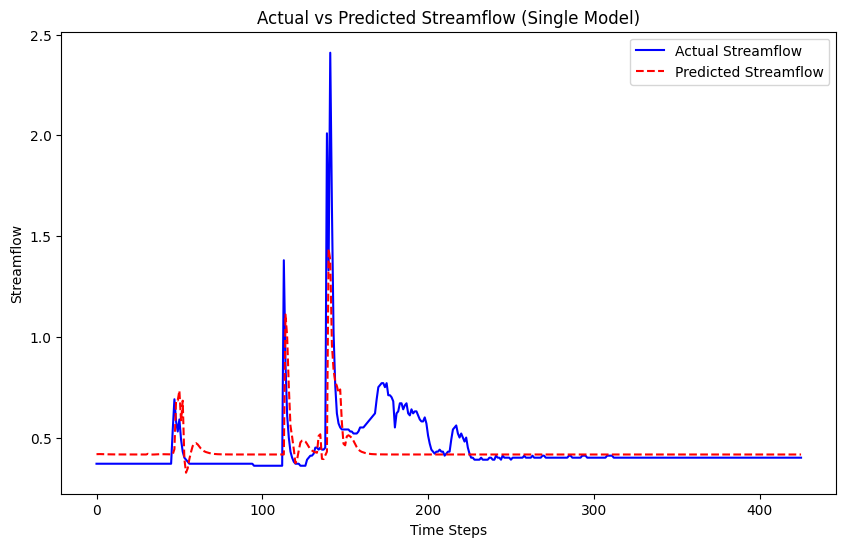

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted streamflow values
plt.figure(figsize=(10, 6))
plt.plot(test_data_y, label='Actual Streamflow', color='blue')
plt.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()
plt.savefig('Combined_Model')